# Backstripping Tool — Stanford EPS 251: Sedimentary Basins

**Developed by [Victor Awosiji](https://profiles.stanford.edu/victor-awosiji) in collaboration with [Prof. Stephan Graham](https://profiles.stanford.edu/stephan-graham) — 1D Airy Isostasy Backstripping**

Backstripping is a fundamental technique for reconstructing the tectonic subsidence history of sedimentary basins by progressively removing the effects of sediment loading and compaction. This tool was created for Stanford EPS 251 (Sedimentary Basins), taught by Professor Stephan Graham, to help students explore basin evolution using a simple, transparent, and reproducible workflow.

This notebook provides a self-contained backstripping environment that allows users to input their own stratigraphic units and automatically calculate:
- Decompacted sediment thicknesses
- Progressive burial and subsidence geometry
- Tectonic subsidence curve
- Depth-to-basement curve

## User Inputs
Students provide:
- Mean age (Ma) of each stratigraphic unit
- Present-day depth to top (km)
- Present-day depth to base (km)

## Computation Framework
The tool applies 1D Airy isostasy backstripping using equations summarized in:
- Allen & Allen (2013), *Basin Analysis*
- Additional sediment compaction relationships from standard sedimentary basin literature
- Calibration using data from the COST-B2 well

## Acknowledgment
An early Excel version of this workflow was developed by [Brian Romans (Virginia Tech)](https://geos.vt.edu/people/Everyone/Brian-Romans.html); this notebook extends that work into a fully automated and open-access Python tool.

In [7]:
#import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# To make your plots a bit nicer
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True


## Physical Assumptions and Parameters

This backstripping tool uses the following physical assumptions:

- **Airy isostasy**: The lithosphere floats on the asthenosphere, with compensation occurring at a depth where pressures are equal.

- **Porosity–depth law**: Porosity decreases exponentially with depth according to:
  $$\phi = \phi_0 \exp(-c z)$$
  where $\phi_0$ is the surface porosity, $c$ is the compaction coefficient, and $z$ is depth.

**Constants (from the lab handout):**
- $\phi_0 = 0.55$ (surface porosity)
- $c = 0.35$ (compaction coefficient, km⁻¹)
- $\rho_w = 1030$ kg/m³ (water density)
- $\rho_{sg} = 2650$ kg/m³ (sediment grain density)
- $\rho_m = 3330$ kg/m³ (mantle density)


In [8]:
def backstrip(
    units_df,
    phi0=0.55,
    c=0.35,
    rho_w=1030.0,
    rho_sg=2650.0,
    rho_m=3330.0,
    water_depth_km=0.0,
    sea_level_change_km=0.0
):
    """
    Perform 1D Airy-isostasy backstripping that mirrors the EPS 251 Excel tool.

    Parameters
    ----------
    units_df : pandas.DataFrame
        Columns required: "unit", "age_Ma", "top_km", "base_km".
        Units can be provided in any order (they are sorted oldest → youngest).
    phi0, c : float
        Parameters for the exponential porosity–depth relation (φ = φ0 exp(−c z)).
    rho_w, rho_sg, rho_m : float
        Densities of water, sediment grains, and mantle (kg/m³).
    water_depth_km : float, optional
        Water depth at the time of deposition (adds directly to tectonic subsidence).
    sea_level_change_km : float, optional
        Applied change in sea level (positive = sea level rise). Included to match the
        Excel template; defaults to zero for our lab exercises.

    Returns
    -------
    pandas.DataFrame
        One row per depositional step (oldest to youngest) with columns:
        "unit", "age_Ma", "depth_to_basement_km", "tectonic_subsidence_km",
        plus reference columns describing the decompacted thickness of the youngest
        unit at that step.
    """
    required_cols = {"unit", "age_Ma", "top_km", "base_km"}
    missing = required_cols - set(units_df.columns)
    if missing:
        raise ValueError(f"units_df is missing required columns: {sorted(missing)}")

    df = units_df.copy().reset_index(drop=True)
    df = df.sort_values("age_Ma", ascending=False).reset_index(drop=True)  # oldest first
    N = len(df)

    if N == 0:
        raise ValueError("units_df must contain at least one stratigraphic unit")

    thick_comp = df["base_km"].values - df["top_km"].values
    mean_z_comp = 0.5 * (df["top_km"].values + df["base_km"].values)
    phi_comp = phi0 * np.exp(-c * mean_z_comp)

    # When a unit is the youngest (uppermost) layer, we decompact it to the surface.
    thick_dec_youngest = thick_comp * (1.0 - phi_comp) / (1.0 - phi0)

    records = []

    for i in range(N):
        sediment_thickness = 0.0
        ts_sum = 0.0

        for k in range(i, -1, -1):  # stack from youngest (i) down to oldest (0)
            thickness = thick_dec_youngest[k] if k == i else thick_comp[k]

            top = sediment_thickness
            base = top + thickness
            mean_z = 0.5 * (top + base)

            phi_back = phi0 * np.exp(-c * mean_z)
            rho_bulk = rho_w * phi_back + rho_sg * (1.0 - phi_back)

            # Airy response for this layer
            ts_contrib = thickness * (rho_m - rho_bulk) / (rho_m - rho_w)
            ts_sum += ts_contrib

            sediment_thickness = base

        depth_to_basement = sediment_thickness
        ts_total = (
            water_depth_km
            + ts_sum
            - sea_level_change_km * (rho_m / (rho_m - rho_w))
        )

        records.append(
            {
                "unit": df["unit"].iloc[i],
                "age_Ma": df["age_Ma"].iloc[i],
                "depth_to_basement_km": depth_to_basement,
                "tectonic_subsidence_km": ts_total,
                "youngest_decomp_thickness_km": thick_dec_youngest[i],
            }
        )

    result_df = pd.DataFrame(records)
    return result_df


In [9]:
# EDIT THIS CELL WITH YOUR OWN DATA
# Provide one row per stratigraphic unit, oldest unit first.
# Example data (from Cardinal-1A well):
data = {
    "unit":   [0, 1, 2, 3, 4],          # Stratigraphic unit ids (do not use their names! python will read them as variables)
    "age_Ma": [180,160, 120, 80, 30],    # mean ages (Ma)
    "top_km": [11.8, 9.4, 5.2, 2.1, 0.0],  # present-day top depth (km) i.e depth to the top of each unit
    "base_km": [15, 11.8, 9.4, 5.2, 2.1] # present-day base depth (km) i.e depth to the base of each unit
}

units_df = pd.DataFrame(data)
print("Input stratigraphic units:")
display(units_df)


Input stratigraphic units:


,unit,age_Ma,top_km,base_km
0,0,180,11.8,15.0
1,1,160,9.4,11.8
2,2,120,5.2,9.4
3,3,80,2.1,5.2
4,4,30,0.0,2.1


**Instructions:**
- Replace the numbers in the data dictionary above with your own stratigraphic unit data.
- Provide mean ages plus present-day depths to the top and base of each unit. Include a final "basement" row *only* if you want the notebook to check the total burial depth (otherwise the depth to the top of the oldest unit already captures the basement depth).
- Units can be supplied in any order; the function sorts them from oldest (largest age) to youngest.
- Optional knobs inside `backstrip` let you prescribe water depth or sea-level change if you want to experiment beyond the default lab setup.


In [10]:
result = backstrip(units_df)

# Create "FOR PLOT" table (sorted by age, youngest to oldest for display)
# this cell does all the calculations needed to plot the backstripping results
plot_table = result.sort_values("age_Ma", ascending=True).copy()
plot_table = plot_table[["unit", "age_Ma", "tectonic_subsidence_km", "depth_to_basement_km"]]
plot_table.columns = ["Unit", "Mean Age (Ma)", "Subsidence (km)", "Depth to Basement (km)"]

print("=" * 60)
print("FOR PLOT")
print("=" * 60)
display(plot_table)

print("\n" + "=" * 60)
print("Full Results (sorted by age, oldest to youngest)")
print("=" * 60)
display(result.sort_values("age_Ma", ascending=False))


FOR PLOT


,Unit,Mean Age (Ma),Subsidence (km),Depth to Basement (km)
4,4,30,5.718963,15.789344
3,3,80,5.564718,15.632800
2,2,120,5.062091,14.534513
1,1,160,3.425623,8.461533
0,0,180,2.886419,7.075181



Full Results (sorted by age, oldest to youngest)


,unit,age_Ma,depth_to_basement_km,tectonic_subsidence_km,youngest_decomp_thickness_km
0,0,180,7.075181,2.886419,7.075181
1,1,160,8.461533,3.425623,5.261533
2,2,120,14.534513,5.062091,8.934513
3,3,80,15.632800,5.564718,5.832800
4,4,30,15.789344,5.718963,2.889344


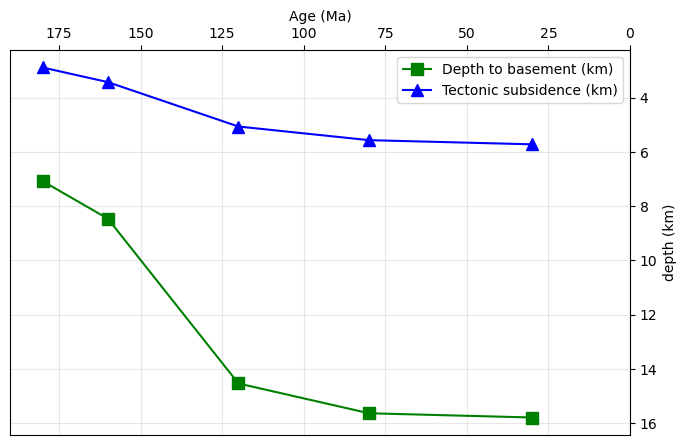

In [11]:
def plot_backstrip(result):
    """
    Plot tectonic subsidence and depth to basement versus age.
    """
    df = result.sort_values("age_Ma", ascending=True)
    ages  = df["age_Ma"].values
    depth = df["depth_to_basement_km"].values
    TS    = df["tectonic_subsidence_km"].values
    
    fig, ax = plt.subplots()
    
    # Age: oldest on the left, 0 Ma on the right
    ax.set_xlabel("Age (Ma)")
    ax.set_xlim(max(ages) + 10, 0)   # add padding
    
    # Move age axis to top
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    ax.tick_params(bottom=False, top=True, labelbottom=False, labeltop=True)
    
    # Depth axis: increasing downward
    ax.set_ylabel("depth (km)")
    ax.invert_yaxis()
    
    # Move depth axis to right
    ax.yaxis.set_label_position('right')
    ax.yaxis.tick_right()
    ax.tick_params(left=False, right=True, labelleft=False, labelright=True)
    
    # Plot depth to basement (green) and tectonic subsidence (blue)
    ax.plot(ages, depth, marker="s", linestyle="-", label="Depth to basement (km)", color="green", markersize=8)
    ax.plot(ages, TS, marker="^", linestyle="-", label="Tectonic subsidence (km)", color="blue", markersize=8)
    
    ax.legend()
    ax.grid(True, linestyle="-", alpha=0.3)
    
    plt.show()

plot_backstrip(result)


## Interpretation Guide

**How to interpret the backstripping results:**

- **Early steep increase in tectonic subsidence** → Indicates active rifting or strong tectonic control during the early stages of basin formation.

- **Later flattening of tectonic subsidence** → Suggests transition to passive margin thermal subsidence, where subsidence slows down exponentially with time due to thermal contraction of the lithosphere.

- **Depth-to-basement curve** → Shows how total sediment thickness evolves through time, reflecting both tectonic subsidence and sediment accumulation.

